In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler

import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))
#print(sys.path)
import util.items as items

In [5]:
import keras
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [6]:
item = 'Yew_logs'

In [7]:
items.getPrices(item)[-10:]

[293, 290, 289, 289, 290, 292, 290, 286, 281, 277]

In [8]:
items.getInfo(item)

{'members': 'False',
 'edible': 'False',
 'update': '/w/Update:Latest_RuneScape_News_(25_March_2002)',
 'quest': 'No',
 'destroy': 'Drop',
 'image': '/w/File:Yew_logs.png',
 'lowAlch': '64',
 'examine': 'Logs cut from a yew tree',
 'highAlch': '96',
 'storeprice': 'N/A',
 'seller': 'N/A',
 'equipable': 'False',
 'weight': '2.0',
 'released': '25 March 2002',
 'storeCurrency': 'N/A',
 'name': 'Yew_logs',
 'alchable': 'True',
 'exchangePrice': '271',
 'tradeable': 'True',
 'buyLimit': '12000',
 'noteable': 'True',
 'stackable': 'False'}

1310 1319 1310 350


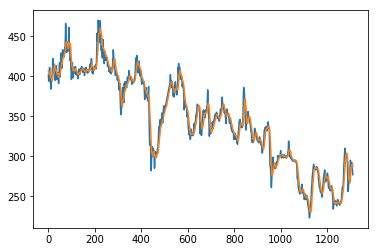

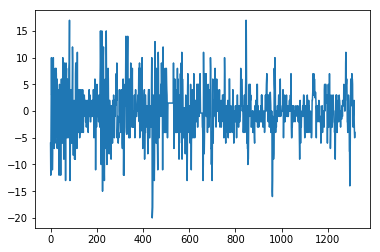

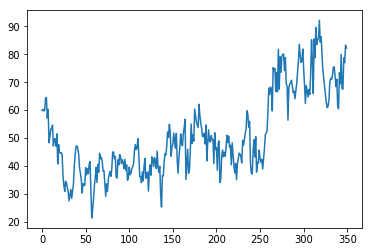

In [9]:
ma = 30
prices = items.getPrices(item)
changes = items.getPriceChanges(item)
movAvg = items.movingAverage(item,ma)
quant = items.getQuants(item)
print(len(movAvg),len(prices),len(movAvg),len(quant))
plt.plot(prices[ma-1:])
plt.plot(movAvg)
plt.plot()
plt.show()
plt.plot(changes)
plt.show()
plt.plot(quant)
plt.show()

In [12]:
def minMax(data):
    d = []
    ma = max(data)
    mi = min(data)
    for i in range(len(data)):
        d.append((data[i]-mi)/(ma-mi))
    return d

def diffArea(data1,data2):
    diff = 0
    arr = []
    for i in range(len(data1)):
        d = data1[i]-data2[i]
        if np.sign(d)!=np.sign(diff):
            diff = 0
        diff+=d
        arr.append(diff)
    return arr

1310 1310


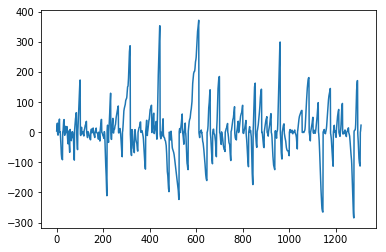

In [13]:
print(len(movAvg),len(prices[-1*len(movAvg):]))
diffA = diffArea(movAvg,prices[-1*len(movAvg):])
plt.plot(diffA)
plt.show()

[-1.32908852 -2.68195658 -0.65265448  0.70021358  2.27855965]


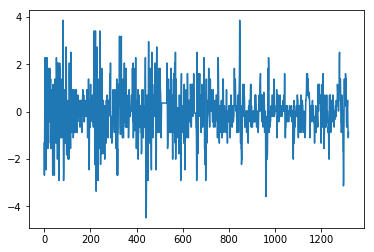

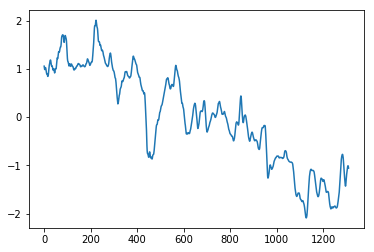

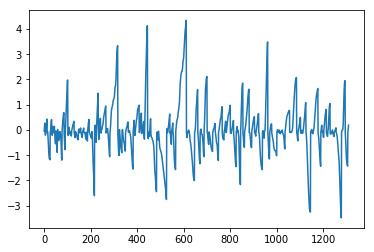

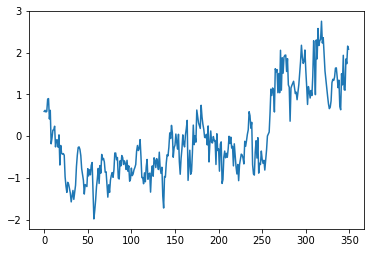

1318 1310 1310 350


In [14]:
scaler = StandardScaler()
s_changes = scaler.fit_transform(np.array(changes).reshape(-1, 1)).reshape(len(changes),)
print(s_changes[0:5])
plt.plot(s_changes)
plt.show()
s_movAvg = scaler.fit_transform(np.array(movAvg).reshape(-1, 1)).reshape(len(movAvg),)
plt.plot(s_movAvg)
plt.show()
s_diffA = scaler.fit_transform(np.array(diffA).reshape(-1,1)).reshape(len(diffA),)
plt.plot(s_diffA)
plt.show()
if len(quant)!=0:
    s_quant = scaler.fit_transform(np.array(quant).reshape(-1,1)).reshape(len(quant),)
    plt.plot(s_quant)
    plt.show()
print(len(s_changes),len(s_movAvg),len(s_diffA),len(s_quant))

In [15]:
def classify(d):
    if d>=0:
        return 1
    if d<0:
        return 0

In [16]:
x = []
y = []
p = []
c = []
size = 10
for i in range(-1*len(s_changes),-1*size,1):
    x.append(s_changes[i:i+size])
    y.append(changes[i+size])
    c.append(classify(changes[i+size]))
    p.append(prices[i+size])
print(x[1],y[0])
print(len(x[0]),len(x[-1]))
print(len(x),len(y),len(p))
#y = keras.utils.to_categorical(y, num_classes=2)

[-2.68195658 -0.65265448  0.70021358  2.27855965  0.70021358  0.92569159
 -0.42717647 -2.45647857 -1.78004454  0.02377955] 0
10 10
1308 1308 1308


1046 1046 131 131 131 131 131
10 [-1.32908852 -2.68195658 -0.65265448  0.70021358  2.27855965  0.70021358
  0.92569159 -0.42717647 -2.45647857 -1.78004454]
0.0
10 [-0.87813249  0.02377955 -0.20169846  0.02377955  0.02377955 -0.20169846
 -0.42717647 -0.65265448  0.92569159  1.1511696 ]
0.0


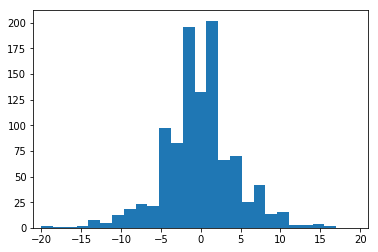

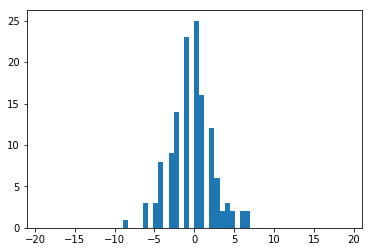

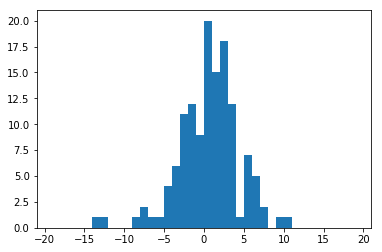

In [27]:
s1 = int(len(y)*.8)
s2  =int(len(y)*.9)

x_train = np.array(x[:s1])
y_train = np.array(y[:s1])
c_train = np.array(c[:s1])

x_val = np.array(x[s1:s2])
y_val = np.array(y[s1:s2])
p_val = np.array(p[s1:s2])
c_val = np.array(c[s1:s2])

x_test = np.array(x[s2:])
y_test = np.array(y[s2:])
p_test = np.array(p[s2:])
c_test = np.array(c[s2:])

print(len(x_train),len(y_train),len(x_val),len(y_val),len(x_test),len(y_test),len(p_test))
print(len(x_train[0]),x_train[0])
print(y_train[0])
print(len(x_test[0]),x_test[0])
print(y_test[0])

limit = max([abs(max(y)),abs(min(y))])+1
plt.xlim(-1*limit,limit)
plt.hist(y_train,25)
plt.show()
plt.xlim(-1*limit,limit)
plt.hist(y_val,25)
plt.show()
plt.xlim(-1*limit,limit)
plt.hist(y_test,25)
plt.show()

In [43]:
model = Sequential()
model.add(Dense(10, input_dim=size, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
sgd = SGD(lr=0.2)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(x_train, y_train,
            validation_data=(x_val,y_val),
            epochs=50,
            batch_size=11)

Train on 1046 samples, validate on 131 samples
Epoch 1/50
1046/1046 [==============================] - 0s 381us/step - loss: 20.5686 - mean_squared_error: 20.5686 - val_loss: 6.9609 - val_mean_squared_error: 6.9609
Epoch 2/50
1046/1046 [==============================] - 0s 109us/step - loss: 19.6991 - mean_squared_error: 19.6991 - val_loss: 6.6597 - val_mean_squared_error: 6.6597
Epoch 3/50
1046/1046 [==============================] - 0s 102us/step - loss: 18.8200 - mean_squared_error: 18.8200 - val_loss: 6.3647 - val_mean_squared_error: 6.3647
Epoch 4/50
1046/1046 [==============================] - 0s 108us/step - loss: 18.0225 - mean_squared_error: 18.0225 - val_loss: 6.0350 - val_mean_squared_error: 6.0350
Epoch 5/50
1046/1046 [==============================] - 0s 93us/step - loss: 17.4195 - mean_squared_error: 17.4195 - val_loss: 5.8284 - val_mean_squared_error: 5.8284
Epoch 6/50
1046/1046 [==============================] - 0s 93us/step - loss: 16.9864 - mean_squared_error: 16.9864

1046/1046 [==============================] - 0s 94us/step - loss: 14.5252 - mean_squared_error: 14.5252 - val_loss: 6.0452 - val_mean_squared_error: 6.0452
Epoch 50/50
1046/1046 [==============================] - 0s 89us/step - loss: 14.5357 - mean_squared_error: 14.5357 - val_loss: 6.0900 - val_mean_squared_error: 6.0900


In [45]:
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

131/131 [==============================] - 0s 345us/step
[9.664791766476005, 9.664791766476005]


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


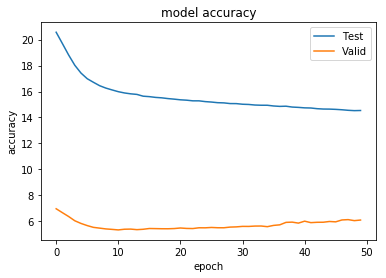

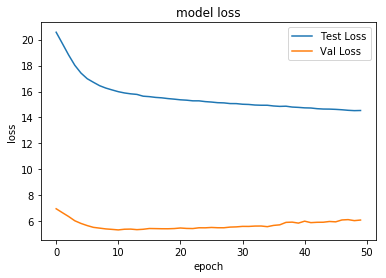

In [46]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'],label='Test')
plt.plot(history.history['val_mean_squared_error'],label='Valid')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label='Test Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

[[ 2.0188112 ]
 [-0.967481  ]
 [ 1.4792145 ]
 [ 0.3508314 ]
 [ 0.14174986]]


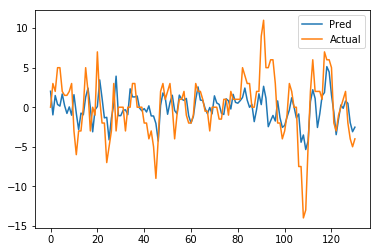

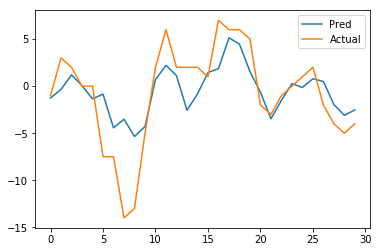

In [47]:
y_pred = model.predict(x_test)
print(y_pred[:5])
plt.plot(y_pred,label='Pred')
plt.plot(y_test,label='Actual')
plt.legend()
plt.show()
plt.plot(y_pred[-30:],label='Pred')
plt.plot(y_test[-30:],label='Actual')
plt.legend()
plt.show()

In [48]:
import util.trading_systems as ts

bl = int(items.getInfo(item)['buyLimit'])
print(len(x_test),len(y_test),len(p_test))
budgets = [10**5,10**6,10**7,10**8,10**9]
mpBest = [([-100],-1)] * len(budgets)
mpBestNoT = [[-100]] * len(budgets)
ppBest = [[-100]] * len(budgets)
bhBest = [[-100]] * len(budgets)
perBest = [[-100]] * len(budgets)

yp = [classify(a) for a in model.predict(x_val)]
for b in range(len(budgets)):
    t = 0
    for i in range(10):
        mp = ts.modelProfit(t,yp,p_val,bl,budgets[b])
        if mp[-1]>mpBest[b][0][-1] and mp[-1]!=0.0:
            mpBest[b] = (mp,t)
        t += .02

yp = [classify(a) for a in model.predict(x_test)]
for b in range(len(budgets)):
    print(budgets[b])
    t = 0
    bhBest[b] = ts.buyAndHold(p_test,bl,budgets[b])
    ppBest[b] = ts.perfectProfit([classify(a) for a in y_test],p_test,bl,budgets[b])
    perBest[b] = ts.persistanceProfit([classify(a) for a in y_test],p_test,bl,budgets[b])
    mpBest[b] = (ts.modelProfit(mpBest[b][1],yp,p_test,bl,budgets[b]),mpBest[b][1])
    mpBestNoT[b] = ts.modelProfit(0,yp,p_test,bl,budgets[b])

131 131 131
100000
1000000
10000000
100000000
1000000000


In [49]:
for b in range(len(budgets)):
    print(budgets[b])
    print('\tModel\n\t',mpBest[b][0][-1],mpBest[b][1])
    print('\tModel No T\n\t',mpBestNoT[b][-1],0)
    print('\tPersistance\n\t',perBest[b][-1])
    print('\tPerfect\n\t',ppBest[b][-1])
    print('\tBuy and Hold\n\t',bhBest[b][-1])

100000
	Model
	 0.39182 0
	Model No T
	 0.39182 0
	Persistance
	 0.36556
	Perfect
	 1.03391
	Buy and Hold
	 0.07353
1000000
	Model
	 0.3924075 0
	Model No T
	 0.3924075 0
	Persistance
	 0.365938
	Perfect
	 1.034761
	Buy and Hold
	 0.073625
10000000
	Model
	 0.23357515 0
	Model No T
	 0.23357515 0
	Persistance
	 0.28762835
	Perfect
	 0.7640691
	Buy and Hold
	 0.0228
100000000
	Model
	 0.02724 0
	Model No T
	 0.02724 0
	Persistance
	 0.08472
	Perfect
	 0.16794
	Buy and Hold
	 0.00228
1000000000
	Model
	 0.002724 0
	Model No T
	 0.002724 0
	Persistance
	 0.008472
	Perfect
	 0.016794
	Buy and Hold
	 0.000228


131 131 130 131


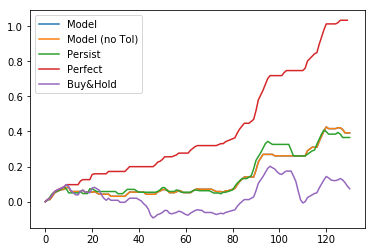

131 131 130 131


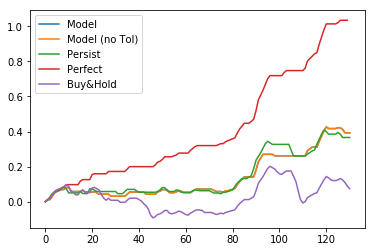

131 131 130 131


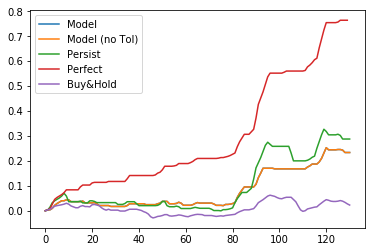

131 131 130 131


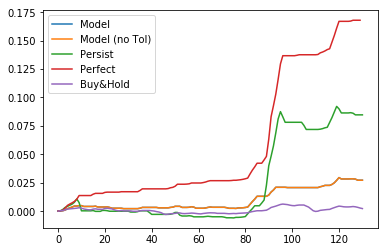

131 131 130 131


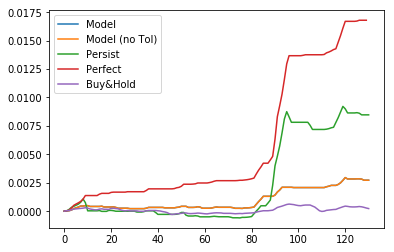

In [50]:
for b in range(len(budgets)):
    print(len(mpBest[b][0]),len(perBest[b]),len(ppBest[b]),len(bhBest[b]))
    plt.plot(mpBest[b][0],label='Model')
    plt.plot(mpBestNoT[b],label='Model (no Tol)')
    plt.plot(perBest[b],label='Persist')
    plt.plot(ppBest[b],label='Perfect')
    plt.plot(bhBest[b],label='Buy&Hold')
    plt.legend()
    plt.show()